# Auto-Encoders for MNIST data

### based on a code by Mike J Innes, found at 
https://github.com/FluxML/model-zoo/blob/master/vision/mnist/vae.jl

First we load the required packages:

In [1]:
using Flux, Flux.Data.MNIST, Statistics 
using Flux: throttle, params
using Flux: @epochs, mse
using Plots
using Colors
using Images

### Loading the data, 5000 random training samples and 5000 random test samples ...

In [2]:
# Load test and training data of size N, 
# and partition training data into mini-batches of M.

X = float.(hcat(vec.(MNIST.images())...)) # .> 0.5 # un-comment this for binary data
Y = MNIST.labels()

N, M = 5000, 100

p_train = rand(1:size(X,2),N)
p_test = rand(1:size(X,2),N)

trainData = [(X[:,p_train[i]],Y[p_train[i]]) for i in Iterators.partition(1:N,M)];
testData = [(X[:,p_test[i]],Y[p_test[i]]) for i in Iterators.partition(1:N,M)];
(N,M)

(5000, 100)

### Inspect the first five MNIST samples

5-element Array{Array{Gray{Float64},2},1}:
 [Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); … ; Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0)]
 [Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); … ; Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0)]
 [Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); … ; Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0)]
 [Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); … ; Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0)]
 [Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); … ; Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0); Gray{Float64}(0.0) Gray{Float64}(0.0) … Gray{Float64}(0.0) Gray{Float64}(0.0)]
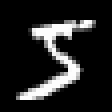
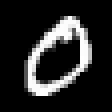
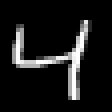
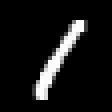
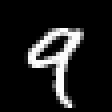

In [3]:
img(x) = Gray.(reshape(x, 28, 28))
[img(X[:,i]) for i in 1:5]

### Display and helper functions

In [4]:
# Show where the innermost layer maps samples on a 2D plot, 
# coloured by each of the classes in the dataset
# includes a function for computing the centroids for each class

my_norm(v) = sqrt(sum(v.^2))

function accuracy(lm, range, centroids)
    sum([ argmin(mapslices(my_norm,centroids.-lm(X[:,i]).data,dims=1))[2]-1==Y[i] 
        for i in range ]) / length(range)
end

function computeClasses(Y)
    sort(unique(Y))
end

function computeCentroids(lm, data, classes) 
    centroids = zeros((2,length(classes)))
    for k in 1:length(data)
        x = first(data[k])
        y = last(data[k])
        for i in 1:length(classes)
            points = lm(x[:,y.==classes[i]])
            centroids[:,i] += Flux.data.(mapslices(mean,points,dims=2))
        end
    end;
    centroids ./= length(data)
    return centroids
end

function plotLatentSpace(lm,data,classes,width=0)
    centroids = computeCentroids(lm, data, classes)
    colors = distinguishable_colors(12, [RGB(1,1,1)])[3:12]
    if ( width > 0 )
        p = scatter(xlim=(-width,width),ylim=(-width,width))
    else
        p = scatter()
    end
    for lab = 1:length(classes)
        scatter!([centroids[1,lab]],[centroids[2,lab]],
                label=classes[lab],markersize=[9],markercolor=[colors[lab]])
    end
    for k in 1:length(data)
        x = first(data[k])
        y = last(data[k])
        for i in 1:length(classes)
            points = Flux.data(lm(x[:,y.==classes[i]]))
            scatter!(points[1,:],points[2,:],label="",
               markercolor=[colors[i]])
        end
    end
    for lab = 1:length(classes)
        scatter!([centroids[1,lab]],[centroids[2,lab]],
                label="",markersize=[9],markercolor=[colors[lab]])
    end
    scatter!(centroids[1,:],centroids[2,:],label="centroids")
    return p
end

plotLatentSpace (generic function with 2 methods)

## Simple Auto-Encoder 

In [5]:
# Latent dimensionality, # hidden units.
Dz, Dh = 2, 500

# encoder
g = Chain(Dense(28^2, Dh, tanh), Dense(Dh, Dz))
# decoder
f = Chain(Dense(Dz, Dh, tanh), Dense(Dh, 28^2, σ))
# model
sae = Chain(g,f)
# loss
loss(X,Y) = mse(sae(X), X)
# callback
evalcb = throttle(() -> ( p=rand(1:N, M); @show(loss(X[:, p],Y[p]))), 20) 
# optimization
opt = ADAM()
# parameters
ps = params(sae);

In [6]:
p=rand(1:N, M)
loss(X[:,p],Y[p])

0.23138637913132953 (tracked)

### train the SAE

In [7]:
@epochs 100 Flux.train!(loss, params(sae), trainData, opt, cb = evalcb)

┌ Info: Epoch 1
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.24126018347549197 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05823063772170243 (tracked)


┌ Info: Epoch 4
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.06049845320567534 (tracked)


┌ Info: Epoch 5
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05579953068841129 (tracked)


┌ Info: Epoch 7
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05550192072099755 (tracked)


┌ Info: Epoch 9
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05286777092887526 (tracked)


┌ Info: Epoch 11
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05731225145747711 (tracked)


┌ Info: Epoch 12
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 13
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.0510136704581569 (tracked)


┌ Info: Epoch 14
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 15
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04981291901459188 (tracked)


┌ Info: Epoch 16
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 17
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.049149179398906534 (tracked)


┌ Info: Epoch 18
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 19
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05041008187952623 (tracked)


┌ Info: Epoch 20
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.044756924866301895 (tracked)


┌ Info: Epoch 21
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 22
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04731542889083264 (tracked)


┌ Info: Epoch 23
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 24
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04825858203542299 (tracked)


┌ Info: Epoch 25
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04891295522191244 (tracked)


┌ Info: Epoch 26
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04535251937340234 (tracked)


┌ Info: Epoch 27
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 28
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04831348778642753 (tracked)


┌ Info: Epoch 29
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04824285432367439 (tracked)


┌ Info: Epoch 30
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04635729026563535 (tracked)


┌ Info: Epoch 31
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 32
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.0435043893682391 (tracked)


┌ Info: Epoch 33
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.0458310005721392 (tracked)


┌ Info: Epoch 34
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04436537370722897 (tracked)


┌ Info: Epoch 35
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 36
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04689565538147464 (tracked)


┌ Info: Epoch 37
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 38
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04865267711546634 (tracked)


┌ Info: Epoch 39
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.045783762341505746 (tracked)


┌ Info: Epoch 40
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 41
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.044434097545766445 (tracked)


┌ Info: Epoch 42
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 43
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.046457264782297586 (tracked)


┌ Info: Epoch 44
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 45
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04283866758516346 (tracked)


┌ Info: Epoch 46
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 47
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.046518228549090976 (tracked)


┌ Info: Epoch 48
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 49
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.045266669535820196 (tracked)


┌ Info: Epoch 50
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04408723672042336 (tracked)


┌ Info: Epoch 51
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 52
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.045005078458519594 (tracked)


┌ Info: Epoch 53
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 54
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04605115728879071 (tracked)


┌ Info: Epoch 55
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 56
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.041648708288559995 (tracked)


┌ Info: Epoch 57
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 58
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.0487486983711742 (tracked)


┌ Info: Epoch 59
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04328677097920273 (tracked)


┌ Info: Epoch 60
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 61
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04428423145260163 (tracked)


┌ Info: Epoch 62
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 63
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04188444419342167 (tracked)


┌ Info: Epoch 64
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 65
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.042055093722466026 (tracked)


┌ Info: Epoch 66
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 67
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.05065003662330336 (tracked)


┌ Info: Epoch 68
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 69
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04911349162407868 (tracked)


┌ Info: Epoch 70
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 71
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.045600741687953215 (tracked)


┌ Info: Epoch 72
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 73
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.046698002943877444 (tracked)


┌ Info: Epoch 74
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 75
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04337852641301413 (tracked)


┌ Info: Epoch 76
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 77
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.045121587564748926 (tracked)


┌ Info: Epoch 78
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 79
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.043796898314308795 (tracked)


┌ Info: Epoch 80
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 81
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04241914889035923 (tracked)


┌ Info: Epoch 82
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 83
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04620230946075007 (tracked)


┌ Info: Epoch 84
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04532729134122539 (tracked)


┌ Info: Epoch 85
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 86
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04576081258261794 (tracked)


┌ Info: Epoch 87
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 88
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04205636600929124 (tracked)


┌ Info: Epoch 89
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 90
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04263211905186468 (tracked)


┌ Info: Epoch 91
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 92
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.040162525209489035 (tracked)


┌ Info: Epoch 93
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 94
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.044837445922714214 (tracked)


┌ Info: Epoch 95
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 96
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04489561504463715 (tracked)


┌ Info: Epoch 97
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 98
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.044516988662145957 (tracked)


┌ Info: Epoch 99
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 100
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss(X[:, p], Y[p]) = 0.04357498509353466 (tracked)


In [8]:
classesMNIST = computeClasses(Y)

10-element Array{Int64,1}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [9]:
centroidsSAE = computeCentroids(g,trainData,classesMNIST)

2×10 Array{Float64,2}:
   3.76602  -41.8058  -13.8039  -23.2622  …  -16.6735   -32.0791  -13.2711 
 -49.6919    15.2081  -31.3558  -30.6614      -1.05279  -18.2604   -5.15588

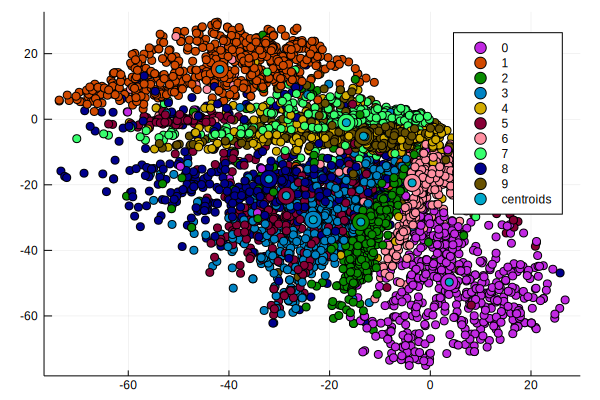

In [10]:
plotLatentSpace(g,trainData,classesMNIST)

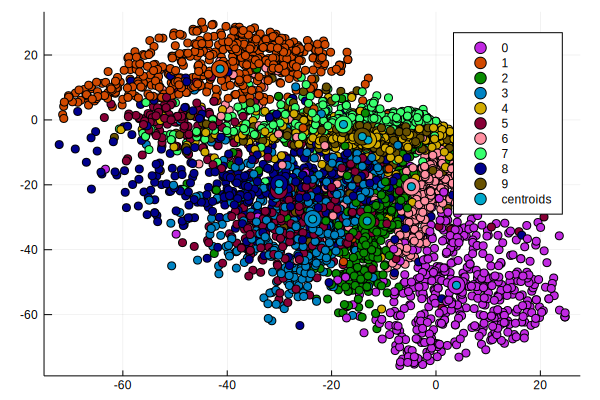

In [11]:
plotLatentSpace(g,testData,classesMNIST)

In [12]:
accuracy(g, p_train, centroidsSAE)

0.549

In [13]:
accuracy(g, p_test, centroidsSAE)

0.5294

In [14]:
savefig(plotLatentSpace(g,trainData,classesMNIST),"sae_latent_space_train_data.png")
savefig(plotLatentSpace(g,testData,classesMNIST),"sae_latent_space_test_data.png")

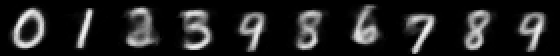

In [15]:
function my_sampleSAE(centroids) 
    [ f(centroids[:,i]) for i in 1:length(classesMNIST) ]
end

sample = hcat(img.(my_sampleSAE(centroidsSAE))...)

In [16]:
save("sae_sample.png", sample)

## A Variational Auto-Encoder

In [17]:
################################# Define Model #################################

# Latent dimensionality, # hidden units.
Dz, Dh = 2, 500

# Components of the encoder, code now has mean and variance part.
A, μ, logσ = Dense(28^2, Dh, tanh), Dense(Dh, Dz), Dense(Dh, Dz)
g_vae(X) = (h = A(X); (μ(h), logσ(h)))

# Latent space Map of input data
lm_vae(X) = g_vae(X)[1]

# sample from latent space.
z_vae(μ, logσ) = μ + exp(logσ) * randn(Float32)

# now the decoder
f_vae = Chain(Dense(Dz, Dh, tanh), Dense(Dh, 28^2, σ))

# A numerically stable logpdf for Bernoulli distribution close to 1 or 0.
logpdfBernoulli(p, y) = y * log(p + eps(Float32)) + (1f0 - y) * log(1 - p + eps(Float32))

# KL-divergence between approximation posterior and N(c, 1) prior.
kl_q_p(c, μ, logσ) = - 0.5f0 * sum( 1f0 .+ logσ .- (exp.(logσ)).^2 .- (μ-c).^2 )

# conditional probability of data given latents.
logp_x_z(x, z) = sum((f_vae(z) - x).^2) #* ( 1 // M)

# try to encourage all classes to group near the origin
place_vae = function (Y)  
    ret = Array{Float64,2}(undef, 2, length(Y))
    for i in 1:length(Y)
        ret[:,i] = zeros((2,1))
    end
    return ret
end

# loss function to be optimised
loss_vae(X,Y) = ((μ̂, logσ̂) = g_vae(X); ĉ = place_vae(Y);  # @show(ĉ);
    pxz = logp_x_z(X, z_vae.(μ̂, logσ̂)); # @show(pxz);
    klqp = kl_q_p(ĉ, μ̂, logσ̂); # @show(klqp);
    ls = ( pxz + klqp) * 1 // M; # @show(ls);
    ls )

# callback, optimiser and paramaters
evalcb_vae = throttle(() -> ( p=rand(1:N, M); @show(loss_vae(X[:, p],Y[p])) ), 20)
opt_vae = ADAM()
ps_vae = params(A, μ, logσ, f_vae);

In [18]:
p=rand(1:N, M)
loss_vae(X[:,p],Y[p])

182.31676554278948 (tracked)

## Train the VAE

In [19]:
@epochs 100 Flux.train!(loss_vae, ps_vae, trainData, opt_vae, cb = evalcb_vae)

┌ Info: Epoch 1
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 183.14260429915507 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 51.931375689715225 (tracked)


┌ Info: Epoch 4
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 55.94038731320516 (tracked)


┌ Info: Epoch 7
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 48.78229307729656 (tracked)


┌ Info: Epoch 9
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 11
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 47.554451431385296 (tracked)


┌ Info: Epoch 12
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 13
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 47.69466217695871 (tracked)


┌ Info: Epoch 14
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 15
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 16
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 47.75095541710298 (tracked)


┌ Info: Epoch 17
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 18
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 49.75762863176352 (tracked)


┌ Info: Epoch 19
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 20
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 21
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.96803573525316 (tracked)


┌ Info: Epoch 22
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 23
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 24
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.07061239255648 (tracked)


┌ Info: Epoch 25
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 26
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 46.77439609303804 (tracked)


┌ Info: Epoch 27
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 28
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 29
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 48.282981695156366 (tracked)


┌ Info: Epoch 30
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 31
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 32
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 46.34050452260177 (tracked)


┌ Info: Epoch 33
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 34
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 35
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.42665830629968 (tracked)


┌ Info: Epoch 36
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 37
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.20638611322651 (tracked)


┌ Info: Epoch 38
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 39
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 40
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 46.653230221985226 (tracked)


┌ Info: Epoch 41
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 42
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.38875993585045 (tracked)


┌ Info: Epoch 43
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 44
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 45
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 46.666482291568826 (tracked)


┌ Info: Epoch 46
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 47
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 46.3036397620911 (tracked)


┌ Info: Epoch 48
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 49
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 50
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.41048212054607 (tracked)


┌ Info: Epoch 51
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 52
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.07996909054882 (tracked)


┌ Info: Epoch 53
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 54
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.47514983607958 (tracked)


┌ Info: Epoch 55
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 56
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 42.948812554306805 (tracked)


┌ Info: Epoch 57
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 58
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.442727994516446 (tracked)


┌ Info: Epoch 59
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 60
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 61
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 41.546812390487894 (tracked)


┌ Info: Epoch 62
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 63
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 64
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.47189839526885 (tracked)


┌ Info: Epoch 65
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 66
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.08789636917674 (tracked)


┌ Info: Epoch 67
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 68
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 69
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.602187619351646 (tracked)


┌ Info: Epoch 70
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 71
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 72
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 42.74787374693221 (tracked)


┌ Info: Epoch 73
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 74
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 75
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 47.238567435346766 (tracked)


┌ Info: Epoch 76
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 77
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.30718856182725 (tracked)


┌ Info: Epoch 78
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 79
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 80
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.07493376631533 (tracked)


┌ Info: Epoch 81
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 82
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 83
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.35660567628094 (tracked)


┌ Info: Epoch 84
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 85
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 42.47384076016912 (tracked)


┌ Info: Epoch 86
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 87
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 88
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 41.87553503873704 (tracked)


┌ Info: Epoch 89
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 90
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 47.24708540781222 (tracked)


┌ Info: Epoch 91
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 92
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 93
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 44.69707545330719 (tracked)


┌ Info: Epoch 94
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 95
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 45.795504625955 (tracked)


┌ Info: Epoch 96
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 97
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 98
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 42.117474283076824 (tracked)


┌ Info: Epoch 99
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 100
└ @ Main /Users/hughmurrell/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


loss_vae(X[:, p], Y[p]) = 43.31353372950117 (tracked)


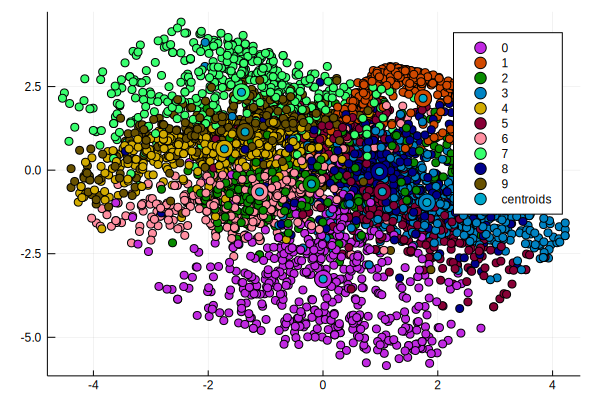

In [20]:
classesMNIST = computeClasses(Y)
plotLatentSpace(lm_vae,trainData,classesMNIST)

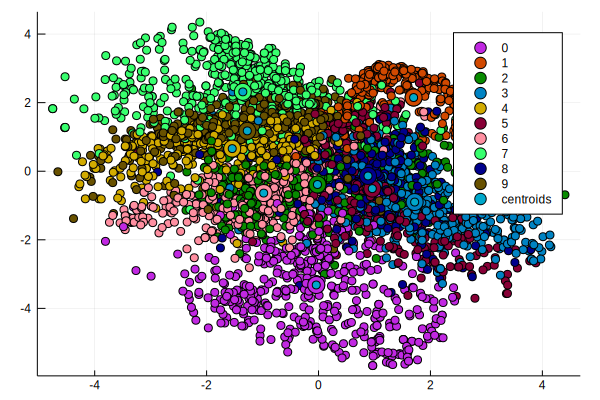

In [21]:
plotLatentSpace(lm_vae,testData,classesMNIST)

In [22]:
centroidsVAE = computeCentroids(lm_vae,trainData,classesMNIST)

2×10 Array{Float64,2}:
  0.0020711  1.7429   -0.20128    1.81006   …  -1.42102   0.984069   -1.35728
 -3.25637    2.14878  -0.413361  -0.967487      2.32917  -0.0413596   1.1435 

In [23]:
accuracy(lm_vae, p_train, centroidsVAE)

0.5586

In [24]:
accuracy(lm_vae, p_test, centroidsVAE)

0.552

In [25]:
savefig(plotLatentSpace(lm_vae,trainData,classesMNIST),"vae_latent_space_train_data.png")
savefig(plotLatentSpace(lm_vae,testData,classesMNIST),"vae_latent_space_test_data.png")

## Semi-Supervised Variational Auto-Encoder

In [26]:
################################# Define Model #################################

# Latent dimensionality, # hidden units.
Dz, Dh = 2, 500

# Components of the encoder, code now has mean and variance part.
A, μ, logσ = Dense(28^2, Dh, tanh), Dense(Dh, Dz), Dense(Dh, Dz)
g_ss(X) = (h = A(X); (μ(h), logσ(h)))

# Latent space Map of input data
lm_ss(X) = g_ss(X)[1]

# sample from latent space.
z_ss(μ, logσ) = μ + exp(logσ) * randn(Float32)

# now the decoder
f_ss = Chain(Dense(Dz, Dh, tanh), Dense(Dh, 28^2, σ))

# A numerically stable logpdf for Bernoulli distribution close to 1 or 0.
logpdfBernoulli(p, y) = y * log(p + eps(Float32)) + (1f0 - y) * log(1 - p + eps(Float32))

# KL-divergence between approximation posterior and N(c, 1) prior.
kl_q_p(c, μ, logσ) = - 0.5f0 * sum( 1f0 .+ logσ .- (exp.(logσ)).^2 .- (μ-c).^2 )

# conditional probability of data given latents.
logp_x_z(x, z) = sum((f_ss(z) - x).^2) #* ( 1 // M)

# try to encourage all classes to group near current class centroid
place_ss = function(Y,c)  
    ret = Array{Float64,2}(undef, 2, length(Y))
    for i in 1:length(Y)
        ret[:,i] = c[:,Y[i]+1]
    end
    return ret
end

updateCentroids = function(lm, data, cents)
    new_cents = zeros(size(cents))
    for k in 1:length(data)
        x = first(data[k])
        y = last(data[k])
        for i in 0:9
            μ̂ = lm(x[:,y.==i]);
            new_cents[:,i+1] += Flux.data.(mapslices(mean,μ̂,dims=2))
        end
    end;
    return ( new_cents ./= length(data) )
end

minSeparation = function(cents)
    seps = sort(unique(pairwise(Euclidean(),cents,dims=2)))
    if ( length(seps) > 1 )
        return seps[2]
    else
        return seps[1]
    end
end

centerCentroids = function(cents)
    return (cents .- mapslices(mean,cents,dims=2))
end 

nansum = function(x)
    return sum(x[.!(isnan.(x))])
end


eforce = function(cents,i)
    d = cents .- cents[:,i]
    dd = mapslices(sum,d.^2,dims=1).^(3/2)
    return( mapslices(nansum,  d ./ ( dd) ,dims=2))
end

espread = function(cents,k=1)
    rs = mapslices(my_norm,cents,dims=1)
    r = maximum(rs)
    dc = hcat([eforce(cents,i) for i in 1:10]...)
    return(cents - ((1 .- rs ./ r) .* k) .* dc)
end

# initial centroids for 10 classes
global centroids_ss = zeros((2,10))

# initial "gravity" for strength of attraction to current centroids
global gravity_ss = 1

# loss function to be optimised
loss_ss(X,Y) = ((μ̂, logσ̂) = g_ss(X); ĉ = place_ss(Y,centroids_ss);  # @show(ĉ);
    pxz = logp_x_z(X, z_ss.(μ̂, logσ̂)); # @show(pxz);
    klqp = kl_q_p(ĉ, μ̂, logσ̂); # @show(klqp);
    ls = ( pxz + gravity_ss * klqp) * 1 // M; # @show(ls);
    ls )

# callback, optimiser and paramaters
evalcb_ss = throttle(() -> ( p=rand(1:N, M); @show(loss_ss(X[:, p],Y[p])) ), 20)
opt_ss = ADAM()
ps_ss = params(A, μ, logσ, f_ss);

In [27]:
p=rand(1:N, M)
loss_ss(X[:,p],Y[p])

181.9680816535863 (tracked)

In [28]:
minSeparation(centroids_ss)

0.0

In [29]:
# Sample from the learned model.
# modelsample() = rand.(Bernoulli.(f(z.(zeros(Dz), zeros(Dz)))))
modelsample( cents, σ ) = [ f_ss(z_ss.(place_ss(i, cents), σ * ones(Dz))) for i in 0:9 ]

modelsample (generic function with 1 method)

In [30]:
function learn_ss(expand = 20, contract =80, minsep=1)
    global gravity_ss
    global centroids_ss
    classesMNIST = computeClasses(Y)
    centroids_ss = updateCentroids(lm_ss,trainData,centroids_ss)
    fname = "animation/vae_ss_"*string(0,pad=3)*".png"
    savefig(plotLatentSpace(lm_ss,trainData,classesMNIST),fname)
    # first expand
    gravity_ss = 1
    for i = 1:expand
        ms = minSeparation(centroids_ss)
        @info "epoch = $i , gravity_ss = $gravity_ss , separation = $ms of $minsep "
        centroids_ss = centerCentroids(centroids_ss)
        Flux.train!(loss_ss, ps_ss, trainData, opt_ss, cb=evalcb_ss)
        centroids_ss = updateCentroids(lm_ss,trainData,centroids_ss)
        @info " accuracy " * string(accuracy(lm_ss, p_train, centroids_ss))
        fname = "animation/vae_ss_"*string(i,pad=3)*".png"
        savefig(plotLatentSpace(lm_ss,trainData,classesMNIST),fname)
    end
    # now contract
     for i = expand+1:expand+contract
        gravity_ss = 1 + i - expand
        ms = minSeparation(centroids_ss)
        @info "epoch = $i , gravity_ss = $gravity_ss , separation = $ms of $minsep "
        # centroids_ss = espread(centroids_ss,10)
        centroids_ss = centerCentroids(centroids_ss)
        centroids_ss = espread(centroids_ss)
        Flux.train!(loss_ss, ps_ss, trainData, opt_ss, cb=evalcb_ss)
        centroids_ss = updateCentroids(lm_ss,trainData,centroids_ss)
        @info " accuracy " * string(accuracy(lm_ss, p_train, centroids_ss))
        fname = "animation/vae_ss_"*string(i,pad=3)*".png"
        savefig(plotLatentSpace(lm_ss,trainData,classesMNIST),fname)
    end
end

learn_ss (generic function with 4 methods)

In [31]:
learn_ss()

┌ Info: epoch = 1 , gravity_ss = 1 , separation = 0.02977317154981641 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 181.36901346104008 (tracked)


┌ Info:  accuracy 0.3418
└ @ Main In[30]:16
┌ Info: epoch = 2 , gravity_ss = 1 , separation = 0.12422518354545506 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.3588
└ @ Main In[30]:16
┌ Info: epoch = 3 , gravity_ss = 1 , separation = 0.2237403015694771 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 53.42504082493369 (tracked)


┌ Info:  accuracy 0.3608
└ @ Main In[30]:16
┌ Info: epoch = 4 , gravity_ss = 1 , separation = 0.2094940515074355 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.342
└ @ Main In[30]:16
┌ Info: epoch = 5 , gravity_ss = 1 , separation = 0.07896493272067052 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 54.2505025329015 (tracked)


┌ Info:  accuracy 0.3594
└ @ Main In[30]:16
┌ Info: epoch = 6 , gravity_ss = 1 , separation = 0.19187062837485855 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.3626
└ @ Main In[30]:16
┌ Info: epoch = 7 , gravity_ss = 1 , separation = 0.2020970729849015 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 48.957933256440676 (tracked)


┌ Info:  accuracy 0.371
└ @ Main In[30]:16
┌ Info: epoch = 8 , gravity_ss = 1 , separation = 0.2612670368259426 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.3934
└ @ Main In[30]:16
┌ Info: epoch = 9 , gravity_ss = 1 , separation = 0.2742232694438024 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 49.78624083930451 (tracked)


┌ Info:  accuracy 0.4246
└ @ Main In[30]:16
┌ Info: epoch = 10 , gravity_ss = 1 , separation = 0.20420262807768227 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.4678
└ @ Main In[30]:16
┌ Info: epoch = 11 , gravity_ss = 1 , separation = 0.3478923249758729 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 43.18897454867942 (tracked)


┌ Info:  accuracy 0.493
└ @ Main In[30]:16
┌ Info: epoch = 12 , gravity_ss = 1 , separation = 0.3863434801754406 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 45.134491672314326 (tracked)


┌ Info:  accuracy 0.5124
└ @ Main In[30]:16
┌ Info: epoch = 13 , gravity_ss = 1 , separation = 0.5096490201911743 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 45.69604136783099 (tracked)


┌ Info:  accuracy 0.519
└ @ Main In[30]:16
┌ Info: epoch = 14 , gravity_ss = 1 , separation = 0.5024201723690495 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.53
└ @ Main In[30]:16
┌ Info: epoch = 15 , gravity_ss = 1 , separation = 0.5422491011268693 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 45.87670147214785 (tracked)


┌ Info:  accuracy 0.53
└ @ Main In[30]:16
┌ Info: epoch = 16 , gravity_ss = 1 , separation = 0.290457039986702 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.5462
└ @ Main In[30]:16
┌ Info: epoch = 17 , gravity_ss = 1 , separation = 0.26984317670101254 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 45.72857138296975 (tracked)


┌ Info:  accuracy 0.5536
└ @ Main In[30]:16
┌ Info: epoch = 18 , gravity_ss = 1 , separation = 0.21782965207953425 of 1 
└ @ Main In[30]:12
┌ Info:  accuracy 0.5638
└ @ Main In[30]:16
┌ Info: epoch = 19 , gravity_ss = 1 , separation = 0.18049914840731773 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 44.43644353649329 (tracked)


┌ Info:  accuracy 0.5726
└ @ Main In[30]:16
┌ Info: epoch = 20 , gravity_ss = 1 , separation = 0.24379180024569383 of 1 
└ @ Main In[30]:12


loss_ss(X[:, p], Y[p]) = 46.9669210080204 (tracked)


┌ Info:  accuracy 0.5808
└ @ Main In[30]:16
┌ Info: epoch = 21 , gravity_ss = 2 , separation = 0.3889031868104327 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 47.36391316390855 (tracked)


┌ Info:  accuracy 0.591
└ @ Main In[30]:30
┌ Info: epoch = 22 , gravity_ss = 3 , separation = 0.27196550695999666 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 49.156485625115906 (tracked)


┌ Info:  accuracy 0.6874
└ @ Main In[30]:30
┌ Info: epoch = 23 , gravity_ss = 4 , separation = 1.169821415068575 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 47.44571300967248 (tracked)


┌ Info:  accuracy 0.7236
└ @ Main In[30]:30
┌ Info: epoch = 24 , gravity_ss = 5 , separation = 1.118723628041518 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.76
└ @ Main In[30]:30
┌ Info: epoch = 25 , gravity_ss = 6 , separation = 1.2648428342706386 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 46.14288193397513 (tracked)


┌ Info:  accuracy 0.7884
└ @ Main In[30]:30
┌ Info: epoch = 26 , gravity_ss = 7 , separation = 1.2927532761383984 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 48.23916031611045 (tracked)


┌ Info:  accuracy 0.8052
└ @ Main In[30]:30
┌ Info: epoch = 27 , gravity_ss = 8 , separation = 1.3397106468732891 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.8266
└ @ Main In[30]:30
┌ Info: epoch = 28 , gravity_ss = 9 , separation = 1.3667306003035384 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 46.79783014746322 (tracked)


┌ Info:  accuracy 0.8384
└ @ Main In[30]:30
┌ Info: epoch = 29 , gravity_ss = 10 , separation = 1.4187998262289465 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 43.893522093734504 (tracked)


┌ Info:  accuracy 0.8484
└ @ Main In[30]:30
┌ Info: epoch = 30 , gravity_ss = 11 , separation = 1.4675282014785587 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 47.94051571586261 (tracked)


┌ Info:  accuracy 0.8568
└ @ Main In[30]:30
┌ Info: epoch = 31 , gravity_ss = 12 , separation = 1.4643026084116884 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.8652
└ @ Main In[30]:30
┌ Info: epoch = 32 , gravity_ss = 13 , separation = 1.5151112639286675 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 45.11915129129134 (tracked)


┌ Info:  accuracy 0.8694
└ @ Main In[30]:30
┌ Info: epoch = 33 , gravity_ss = 14 , separation = 1.546079812115467 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.8742
└ @ Main In[30]:30
┌ Info: epoch = 34 , gravity_ss = 15 , separation = 1.5939085417675538 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 46.67248685371929 (tracked)


┌ Info:  accuracy 0.8796
└ @ Main In[30]:30
┌ Info: epoch = 35 , gravity_ss = 16 , separation = 1.6234887912207272 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.883
└ @ Main In[30]:30
┌ Info: epoch = 36 , gravity_ss = 17 , separation = 1.6527775989780455 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 48.91203633864213 (tracked)


┌ Info:  accuracy 0.8878
└ @ Main In[30]:30
┌ Info: epoch = 37 , gravity_ss = 18 , separation = 1.7070033613704454 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.8894
└ @ Main In[30]:30
┌ Info: epoch = 38 , gravity_ss = 19 , separation = 1.7486011389444598 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 48.90206934574966 (tracked)


┌ Info:  accuracy 0.8942
└ @ Main In[30]:30
┌ Info: epoch = 39 , gravity_ss = 20 , separation = 1.7749426856096249 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.896
└ @ Main In[30]:30
┌ Info: epoch = 40 , gravity_ss = 21 , separation = 1.8021886728485217 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 46.76276082968725 (tracked)


┌ Info:  accuracy 0.8992
└ @ Main In[30]:30
┌ Info: epoch = 41 , gravity_ss = 22 , separation = 1.8325301632888953 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.8982
└ @ Main In[30]:30
┌ Info: epoch = 42 , gravity_ss = 23 , separation = 1.8572127105508374 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 49.30531634014047 (tracked)


┌ Info:  accuracy 0.9026
└ @ Main In[30]:30
┌ Info: epoch = 43 , gravity_ss = 24 , separation = 1.8501647225240032 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.904
└ @ Main In[30]:30
┌ Info: epoch = 44 , gravity_ss = 25 , separation = 1.8856873992857652 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 53.567529482804844 (tracked)


┌ Info:  accuracy 0.9044
└ @ Main In[30]:30
┌ Info: epoch = 45 , gravity_ss = 26 , separation = 1.9118745836490816 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9038
└ @ Main In[30]:30
┌ Info: epoch = 46 , gravity_ss = 27 , separation = 1.924461001140143 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 52.65407815778874 (tracked)


┌ Info:  accuracy 0.9058
└ @ Main In[30]:30
┌ Info: epoch = 47 , gravity_ss = 28 , separation = 1.8952299296800763 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9076
└ @ Main In[30]:30
┌ Info: epoch = 48 , gravity_ss = 29 , separation = 1.8948618368874084 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 51.266031464167746 (tracked)


┌ Info:  accuracy 0.9068
└ @ Main In[30]:30
┌ Info: epoch = 49 , gravity_ss = 30 , separation = 1.9111084320185923 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.91
└ @ Main In[30]:30
┌ Info: epoch = 50 , gravity_ss = 31 , separation = 1.9366856401598815 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9112
└ @ Main In[30]:30
┌ Info: epoch = 51 , gravity_ss = 32 , separation = 1.9671549609767032 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 52.88455150033109 (tracked)


┌ Info:  accuracy 0.9104
└ @ Main In[30]:30
┌ Info: epoch = 52 , gravity_ss = 33 , separation = 1.9717369302881205 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9096
└ @ Main In[30]:30
┌ Info: epoch = 53 , gravity_ss = 34 , separation = 1.9714730503739533 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 59.2096034260203 (tracked)


┌ Info:  accuracy 0.911
└ @ Main In[30]:30
┌ Info: epoch = 54 , gravity_ss = 35 , separation = 1.9902307796823195 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9114
└ @ Main In[30]:30
┌ Info: epoch = 55 , gravity_ss = 36 , separation = 1.9944998581417266 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 52.90207985379835 (tracked)


┌ Info:  accuracy 0.9104
└ @ Main In[30]:30
┌ Info: epoch = 56 , gravity_ss = 37 , separation = 2.023652301294064 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.911
└ @ Main In[30]:30
┌ Info: epoch = 57 , gravity_ss = 38 , separation = 2.0237815919136786 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 64.0111174925082 (tracked)


┌ Info:  accuracy 0.9122
└ @ Main In[30]:30
┌ Info: epoch = 58 , gravity_ss = 39 , separation = 2.0522948186003482 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9108
└ @ Main In[30]:30
┌ Info: epoch = 59 , gravity_ss = 40 , separation = 2.0740696342227625 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 61.124426458880954 (tracked)


┌ Info:  accuracy 0.9124
└ @ Main In[30]:30
┌ Info: epoch = 60 , gravity_ss = 41 , separation = 2.108515467719452 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9118
└ @ Main In[30]:30
┌ Info: epoch = 61 , gravity_ss = 42 , separation = 2.1187519761723608 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 59.39388042099272 (tracked)


┌ Info:  accuracy 0.9094
└ @ Main In[30]:30
┌ Info: epoch = 62 , gravity_ss = 43 , separation = 2.105094270495824 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9118
└ @ Main In[30]:30
┌ Info: epoch = 63 , gravity_ss = 44 , separation = 2.09960706394313 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 55.418590391541585 (tracked)


┌ Info:  accuracy 0.9108
└ @ Main In[30]:30
┌ Info: epoch = 64 , gravity_ss = 45 , separation = 2.0426560819602457 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.912
└ @ Main In[30]:30
┌ Info: epoch = 65 , gravity_ss = 46 , separation = 2.017637224216213 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 50.57610872040959 (tracked)


┌ Info:  accuracy 0.91
└ @ Main In[30]:30
┌ Info: epoch = 66 , gravity_ss = 47 , separation = 2.016656048715511 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.911
└ @ Main In[30]:30
┌ Info: epoch = 67 , gravity_ss = 48 , separation = 2.073475282417664 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.912
└ @ Main In[30]:30
┌ Info: epoch = 68 , gravity_ss = 49 , separation = 2.100001723534095 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 53.47947449245296 (tracked)


┌ Info:  accuracy 0.9106
└ @ Main In[30]:30
┌ Info: epoch = 69 , gravity_ss = 50 , separation = 2.1023407339544273 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9096
└ @ Main In[30]:30
┌ Info: epoch = 70 , gravity_ss = 51 , separation = 2.1242245792490833 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 71.62417362948915 (tracked)


┌ Info:  accuracy 0.9104
└ @ Main In[30]:30
┌ Info: epoch = 71 , gravity_ss = 52 , separation = 2.150477747326098 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9134
└ @ Main In[30]:30
┌ Info: epoch = 72 , gravity_ss = 53 , separation = 2.154073830641331 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 55.43696534154427 (tracked)


┌ Info:  accuracy 0.9128
└ @ Main In[30]:30
┌ Info: epoch = 73 , gravity_ss = 54 , separation = 2.171588175915554 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9122
└ @ Main In[30]:30
┌ Info: epoch = 74 , gravity_ss = 55 , separation = 2.194172488379887 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 60.437519102387995 (tracked)


┌ Info:  accuracy 0.9114
└ @ Main In[30]:30
┌ Info: epoch = 75 , gravity_ss = 56 , separation = 2.233597152614579 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.912
└ @ Main In[30]:30
┌ Info: epoch = 76 , gravity_ss = 57 , separation = 2.2816853668273955 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 59.10269166493121 (tracked)


┌ Info:  accuracy 0.9126
└ @ Main In[30]:30
┌ Info: epoch = 77 , gravity_ss = 58 , separation = 2.3097444673388394 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9132
└ @ Main In[30]:30
┌ Info: epoch = 78 , gravity_ss = 59 , separation = 2.3226964495394222 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 82.04912140985844 (tracked)


┌ Info:  accuracy 0.913
└ @ Main In[30]:30
┌ Info: epoch = 79 , gravity_ss = 60 , separation = 2.334555365981765 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9136
└ @ Main In[30]:30
┌ Info: epoch = 80 , gravity_ss = 61 , separation = 2.351175539538021 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 59.96843686871878 (tracked)


┌ Info:  accuracy 0.9134
└ @ Main In[30]:30
┌ Info: epoch = 81 , gravity_ss = 62 , separation = 2.364154555201295 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9136
└ @ Main In[30]:30
┌ Info: epoch = 82 , gravity_ss = 63 , separation = 2.3848163023064655 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 75.85328331382877 (tracked)


┌ Info:  accuracy 0.9128
└ @ Main In[30]:30
┌ Info: epoch = 83 , gravity_ss = 64 , separation = 2.4028441244417165 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.913
└ @ Main In[30]:30
┌ Info: epoch = 84 , gravity_ss = 65 , separation = 2.3787934135249387 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9128
└ @ Main In[30]:30
┌ Info: epoch = 85 , gravity_ss = 66 , separation = 2.2890684314735843 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 98.9224110351495 (tracked)


┌ Info:  accuracy 0.9126
└ @ Main In[30]:30
┌ Info: epoch = 86 , gravity_ss = 67 , separation = 2.2284071007907524 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9128
└ @ Main In[30]:30
┌ Info: epoch = 87 , gravity_ss = 68 , separation = 2.1622796031224603 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 83.36792612093146 (tracked)


┌ Info:  accuracy 0.9122
└ @ Main In[30]:30
┌ Info: epoch = 88 , gravity_ss = 69 , separation = 2.1071354457920215 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9112
└ @ Main In[30]:30
┌ Info: epoch = 89 , gravity_ss = 70 , separation = 2.0235563874687394 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 64.00212576682421 (tracked)


┌ Info:  accuracy 0.912
└ @ Main In[30]:30
┌ Info: epoch = 90 , gravity_ss = 71 , separation = 1.9575444889382525 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9116
└ @ Main In[30]:30
┌ Info: epoch = 91 , gravity_ss = 72 , separation = 1.9044345734841435 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 61.01484545002957 (tracked)


┌ Info:  accuracy 0.9128
└ @ Main In[30]:30
┌ Info: epoch = 92 , gravity_ss = 73 , separation = 1.8839046679712954 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.912
└ @ Main In[30]:30
┌ Info: epoch = 93 , gravity_ss = 74 , separation = 1.850816347110911 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 94.81624369713606 (tracked)


┌ Info:  accuracy 0.9114
└ @ Main In[30]:30
┌ Info: epoch = 94 , gravity_ss = 75 , separation = 1.824055416296106 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9104
└ @ Main In[30]:30
┌ Info: epoch = 95 , gravity_ss = 76 , separation = 1.8142353790768437 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 82.3858183316989 (tracked)


┌ Info:  accuracy 0.9102
└ @ Main In[30]:30
┌ Info: epoch = 96 , gravity_ss = 77 , separation = 1.7825213166143523 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9092
└ @ Main In[30]:30
┌ Info: epoch = 97 , gravity_ss = 78 , separation = 1.7704291004632329 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9094
└ @ Main In[30]:30
┌ Info: epoch = 98 , gravity_ss = 79 , separation = 1.740884737370153 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 94.06643598074042 (tracked)


┌ Info:  accuracy 0.9082
└ @ Main In[30]:30
┌ Info: epoch = 99 , gravity_ss = 80 , separation = 1.7345079249590087 of 1 
└ @ Main In[30]:24
┌ Info:  accuracy 0.9072
└ @ Main In[30]:30
┌ Info: epoch = 100 , gravity_ss = 81 , separation = 1.6920943422139145 of 1 
└ @ Main In[30]:24


loss_ss(X[:, p], Y[p]) = 87.41533784429312 (tracked)


┌ Info:  accuracy 0.907
└ @ Main In[30]:30


In [32]:
accuracy(lm_ss,p_train,centroids_ss)

0.9998

In [33]:
accuracy(lm_ss,p_test,centroids_ss)

0.9094

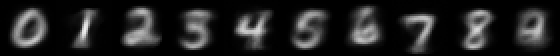

In [35]:
################################# Sample Output ##############################
sample = hcat(img.(modelsample(centroids_ss, 0.001))...)

In [36]:
save("vae_ss_sample.png", sample)

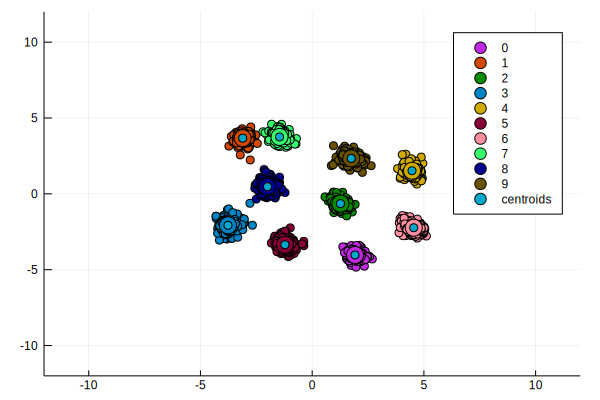

In [37]:
classesMNIST = computeClasses(Y)
plotLatentSpace(lm_ss,trainData,classesMNIST,12)

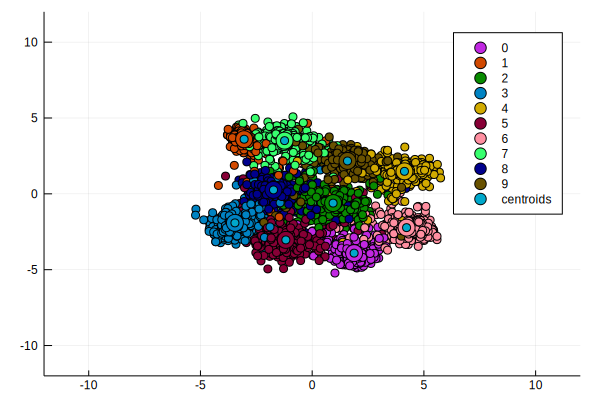

In [38]:
plotLatentSpace(lm_ss,testData,classesMNIST,12)

In [39]:
savefig(plotLatentSpace(lm_ss,trainData,classesMNIST),"vae_ss_encoder_train_data.png")
savefig(plotLatentSpace(lm_ss,testData,classesMNIST),"vae_ss_encoder_test_data.png")

In [40]:
#Show what points on the innermost 2D plane map to in terms of image representations 
#"Granularity" controls how finely these points are sampled
function plot_decoder(granularity::Int)    
    hcat([vcat(img.([Tracker.data(f_ss(z_ss.([i,1-j], zeros(Dz)))) 
                        for j in -10:20/granularity:10])...) 
            for i in -10:20/granularity:10]...)
end;

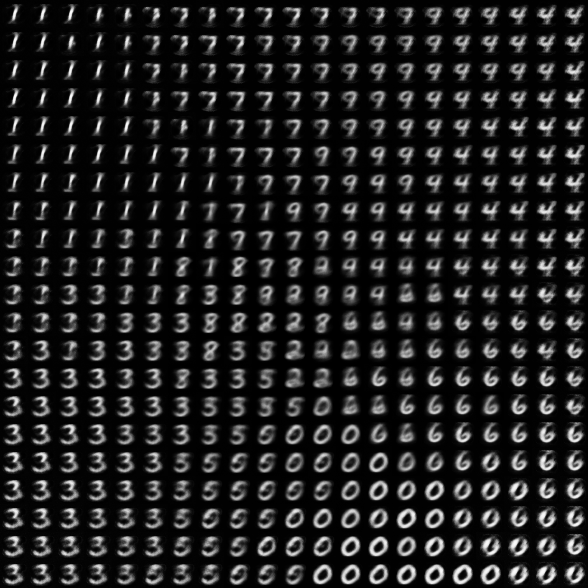

In [41]:
plot_decoder(20)

In [42]:
save("vae_ss_decoder.png",plot_decoder(20))